# Inkrementalni sistemi preporuka #

Najpre učitajmo neophodne biblioteke za kreiranje ISGD (Incremental Stochastic Gradient Decent) modela i njegovo testiranje. Klasa Incremental_SGD je inicijalno odvojena u poseban fajl zbog bolje čitljivosti ali će za potrebe prezentacije biti dodata i u ovu svesku.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
# from SGD import Incremental_SGD

Učitavamo i skup podataka nad kojim ćemo raditi u nastavku. Korišćen skup podataka je [MovieLens 1m](https://grouplens.org/datasets/movielens/1m/), odnosno ratings.dat deo pomenutog skupa. Kako bi podaci bili ispravno učitani neophodno je setovati :: kao delimiter i zadati imena kolona, koje su nazvane user_id, movie_id, rating i timestamp. Kolone user_id i movie_id predstavljaju ID korisnika, odnosno filma i to tako da se broje počevši od broja 1. Kolona rating predstavlja ocenu koju je korisnik user_id dodelio filmu movie_id, a timestamp vremenski trenutak kada je ta ocena dodeljena.

In [5]:
# Ucitavamo skup podataka koji sadrzi ocene
ratings_df = pd.read_csv('./dataset/ml-1m/ratings.dat', delimiter='::', engine='python', header=None, names=['user_id', 'movie_id', 'rating', 'timestamp'])

In [6]:
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Proveravamo osnovne inormacije o skupu podataka. Najpre vidimo broj vrednosti koje nisu null za svaku kolonu kao i njihov tip. Zatim ponalazimo broj korisnika u posmatranom skupu podataka, broj filmova, kao i broj i skalu ocena, gde vidimo da su ocene brojevi od 1 do 5. 

In [7]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [8]:
n_users = ratings_df['user_id'].unique().shape[0]
print(f'Broj korisnika u skupu podataka: {n_users}')

Broj korisnika u skupu podataka: 6040


In [9]:
n_movies = ratings_df['movie_id'].unique().shape[0]
print(f'Broj filmova u skupu podataka: {n_movies}')

Broj filmova u skupu podataka: 3706


In [10]:
print(f'Broj ocena u skupu podataka: {ratings_df.shape[0]}')

Broj ocena u skupu podataka: 1000209


In [11]:
all_ratings = np.unique(ratings_df['rating'])
print(f'Skala ocena: {all_ratings}')

Skala ocena: [1 2 3 4 5]


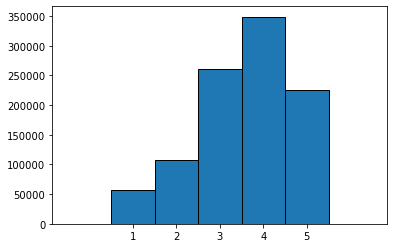

In [12]:
plt.hist(ratings_df['rating'],bins=np.arange(8)-0.5,edgecolor='black')
plt.xticks(np.unique(ratings_df['rating']))
plt.show()

Algoritam koji ćemo videti u nastavku zahteva da radimo samo sa pozitivnim ocenama. Ideja se zasniva na tome da je za implementaciju sistema preporuke dovoljno posmatrati samo pozitivne ocene, koje nam govore da se korisniku nešto svidelo, dok negativne ocene zanemarujemo. Pozitivnom ocenom se smatra ocena 5 na skali od 1-5, odnosno u relaksiranom slučaju možemo pozitivnim smatrati sve ocene veće od 4. U skupu podataka ocene koje posmatramo su celobrojne vrednosti, te ćemo u nastavku posmatrati ponašanje nad skupom podataka koji pozitivnim ocenama koje posmatramo smatra samo ocenu 5 koji ćemo smatrati "strogom" varijantom, odnosno nad skupom koji sadrži i ocene 4 i 5 koji ćemo smatrati "relaksiranom" varijantom problema. 

Kako bismo mogli lako da odradimo pomenuta filtriranja definišemo prepare_data koja će biti korišćena u nastavku. Jedini obavezan parametar je skup podataka koji želimo da filtriramo, dok ostali parametri imaju podrazumevane vrednosti takve da će ukoliko se ne prosledi parametar value filter biti samo ocene 5, ako se ne prosledi parametar remove skup podataka biće transformisan samo u kategoričke vrednosti bez izbacivanja onih vrsta u kojima je ocena manja od value. Ukoliko je vrednost parametara preference True generiše se nova kolona skupa podataka koja ima vrednost 1 ukoliko je ocena veća od vrednosti zadate kao value, a 0 u suprotnom. Ova kola biće nam potrebna za prikaz rada biblioteke cf_step.

In [13]:
def prepare_data(data, value=5, remove=False, preferences=False):
    dataset = data.copy()
    
    # Izbacujemo podatke
    if remove:
        dataset = dataset[(dataset['rating'] >= value)]
        n_users = dataset['user_id'].unique().shape[0]
        print(f'Broj korisnika nakon filtiranja: {n_users}')
        n_movies = dataset['movie_id'].unique().shape[0]
        print(f'Broj filmova nakon filtriranja: {n_movies}')
        print(f'Broj ocena nakon filtriranja: {dataset.shape[0]}')
        
    # Transformacija id_eva u slucaju da postoje neke nedostajuce vrednosti
    dataset['user_id'] = dataset['user_id'].astype('category')
    dataset['movie_id'] = dataset['movie_id'].astype('category')
    dataset['user_code'] = dataset['user_id'].cat.codes.astype(int)
    dataset['movie_code'] = dataset['movie_id'].cat.codes.astype(int)
    
    # Izbacujemo podatke koji nam ne trebaju i reorganizujemo
    if preferences:
        dataset['preference'] = np.where(dataset['rating'] >= value, 1, 0)
        dataset = dataset[['user_code', 'movie_code', 'rating', 'timestamp', 'preference']]
    else:
        dataset = dataset[['user_code', 'movie_code', 'rating', 'timestamp']]
    
    # Kako bismo podatke mogli da koristimo inkrementlno, sortiramo ih po vremenu
    dataset_sorted = dataset.sort_values(by='timestamp').reset_index(drop=True)
    
    return dataset

Transformišemo skup podataka tako da izbacujemo sve vrste u kojima ocena nije jednaka 5 i proveravamo koliko podataka imamo nakon pripreme podataka.

In [14]:
ratings_df_only5 = prepare_data(ratings_df, 5, True)
ratings_df_only5.head()

Broj korisnika nakon filtiranja: 6014
Broj filmova nakon filtriranja: 3232
Broj ocena nakon filtriranja: 226310


,user_code,movie_code,rating,timestamp
0,0,942,5,978300760
4,0,1885,5,978824291
6,0,1033,5,978302039
7,0,2278,5,978300719
10,0,519,5,978824268


U okviru klase Incremental_SGD napisana je implementacija ISGD zasnovana na algoritmu preuzetom iz ["Online bagging for recommendation with incremental matrix factorization"](https://ceur-ws.org/Vol-2069/STREAMEVOLV2.pdf). Podaci nad kojima će biti rađeno su informacije o parovima koji predstavljaju posmatrane korisnike (u) i filmove (i), kao i ocenama koje je posmatrani korsnik dao posmatranom filmu, sa ograničenjem da ćemo u ovom slučaju posmatrati samo pozitivne interakcije između korisnika i filma. Matrice A i B odnose se respektivno na korisnike i filmove i njihove dimenzije su broj korisnika, odnosno filmova i parametar k koji ograničava posmatrani prostor korisnika i filmova. Parametar l2_reg je regularizacioni parametar, dok learning_rate definiše korak učenja. 
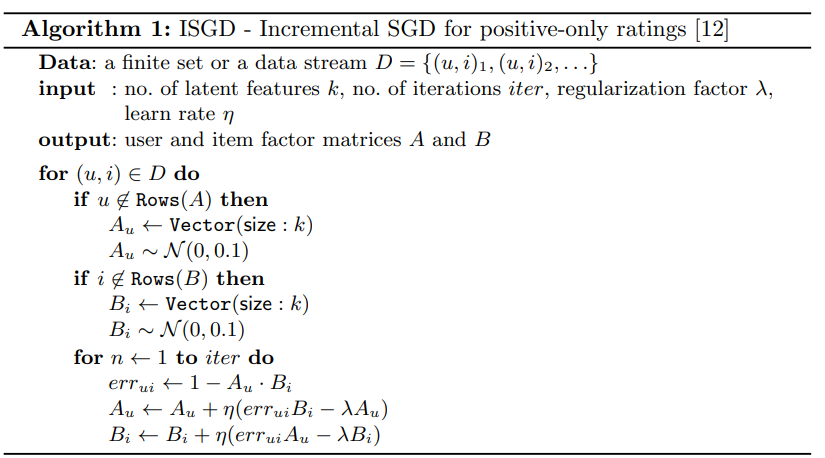
Algoritam najpre proverava da li je posmatrani korisnik poznat, ukoliko nije kreira se novi korisnik sa karakteristikama nasumično odabranim iz normalne raspodele. Isti princip važi i za nove filmove. Kako se bavimo samo pozivtivnim ocenama cilj nam je uvek 1, zbog čega prilikom računanja dobijeno predviđanje oduzimamo od jedinice. Nakon toga ažuriramo podatke matrice korisnika i matrice filmova prema formuli datoj na slici čime kompletiramo jedan korak ovog algoritma.
Pomenuta klasa sadrži metode update, reccomend, train i step koji će biti korišćeni u nastavku. Metode train i step predstavljaju uopštenja upotrebe metoda update za treniranje inicjalnog dela skupa podataka, odnosno za korak inkrementalnog modela koji računa preporuku nakon čega radi i ažuriranje novim podacima.

In [15]:
# Klasa koja implementira inkrementalni stohasticki gradijentni spust (Incremental Stochastic Gradient Descent)
class Incremental_SGD:
    # Inicijalizacija
    def __init__(self, dataset, n_users, n_movies, k, l2_reg=0.01, learning_rate=0.05):
        self.dataset = dataset[['user_code', 'movie_code', 'rating']].copy()
        self.n_users = n_users
        self.n_movies = n_movies
        self.k = k
        self.l2_reg = l2_reg
        self.learning_rate = learning_rate
        self.known_users = np.array([])
        self.known_movies = np.array([])
        self.A = np.random.normal(0.0, 0.1, (n_users, self.k))
        self.B = np.random.normal(0.0, 0.1, (n_movies, self.k))
        self.history_m = np.zeros((n_users, n_movies))

    # Azuriramo novim podacima
    def update(self, user, movie, rating, train=False):
        # Proveravamo da li korisnik vec postoji u listi poznatih korisnika i dodajemo ga ukoliko ne postoji
        if user not in self.known_users: 
            self.known_users = np.append(self.known_users, user)
        user_v = self.A[user]
        # Proveravamo da li film vec postoji u listi poznatih filmova i dodajemo ga ukoliko ne postoji
        if movie not in self.known_movies: 
            self.known_movies = np.append(self.known_movies, movie)
        movie_v = self.B[movie]
        # Ukoliko smo u fazi treniranja padaci se vec nalaze u datasetu
        if not train:
            # Dodajemo podatak u dataset
            self.dataset.loc[len(self.dataset)] = [user, movie, rating]
        err = 1. - np.dot(user_v, movie_v)
        self.A[user] = user_v + self.learning_rate * (err * movie_v - self.l2_reg * user_v)
        self.B[movie] = movie_v + self.learning_rate * (err * user_v - self.l2_reg * movie_v)
        self.history_m[user, movie] = 1

    # Predvidjamo n najboljih preporuka
    def recommend(self, user, n):
        # Ako korisnik nije vec poznat preporucujemo mu n najbolje ocenjenih filmova
        if user not in self.known_users: 
            return self.dataset['movie_code'].value_counts().head(n)
        # Lista filmova koje treba preporuciti korisniku
        recommendations = []
        scores = np.abs(1. - np.dot(np.array([self.A[user]]), self.B.T)).reshape(self.B.shape[0])
        i = 0
        for movie in np.argsort(scores):
            # Ukoliko je korisnik vec gledao film preskacemo ga
            if self.history_m[user, movie] == 1: 
                continue
            recommendations.append(movie)
            i += 1
            # Ukoliko imamo n najboljih filmova koje korisnik nije pogledao prekidamo
            if i == n: 
                break
        return recommendations
    
    # Treniramo model na pocetnom skupu podataka
    def train(self):
        n = self.dataset.shape[0]
        for i in tqdm(range(n)):
            user, movie, rating = self.dataset.iloc[i]
            self.update(user, movie, rating, train=True)
    
    # Racunamo preporuku za datog korisnika i azuriramo podatke
    def step(self, user, movie, rating, N):
        recommendations = self.recommend(user, N)
        self.update(user, movie, rating)
        return recommendations

Radi lakšeg pozivanja algoritma za različite skupove podataka, kao drugačiji broj predviđanja definišemo start_incremental_sgd koja poziva ISGD, podrazumevano radi treniranje nad 20% skupa podataka, a nakon toga kreće da predviđa buduće vrednosti i inkrementalno vrši ažuriranja prilikom svakog koraka. Takođe, kako bi prikaz rezultata bio lakši kao rezultat vraća recall, i ISGD koji se dalje može koristiti za nova predviđanja i dalja ažuriranja.

In [36]:
def start_incremental_sgd(data, N=10, window_size=5000, train_size=0.2, k=100, l2_reg=0.01, learning_rate=0.05):
    n_users = data['user_code'].unique().shape[0]
    n_movies = data['movie_code'].unique().shape[0]
    
    # Inicijalizacija, uzimamo prvih train_size za inicijalizaciju
    n_train = int(data.shape[0]*train_size)
    isgd = Incremental_SGD(data.head(n_train), n_users, n_movies, k, l2_reg, learning_rate)
    
    # Treniramo koristeci trening skup koji smo setovali tokom inicijalizacije
    isgd.train()
    
    avgs = []
    is_recommended = []
    for i in tqdm(range(n_train, data.shape[0])):
        user, movie, rating, timestamp = data.iloc[i]
        # Pronadji N preporuka za korisnika
        recommendations = isgd.step(user, movie, rating, N)
        # Ukoliko je dati film preporucen 1, ako nije 0
        recommended = 1 if (movie in recommendations) else 0
        # Recall zelimo da racunamo samo za poznate korisnike
        if user in isgd.known_users:     
            is_recommended.append(recommended)
            n = len(is_recommended)
            if n > window_size: 
                del is_recommended[0]
                n -= 1
            if n == window_size:
                avgs.append(sum(is_recommended) / float(n))
    return avgs, isgd

Primenimo sada prethodno opisani algoritam na skupu podataka koji kao poyitivne ocene koje posmatramo definiše samo ocenu 5 i to u slučajevima da treba korisniku predložiti 5, 10, 15 ili 20 filmova.

In [37]:
avgs_only5_5, isgd = start_incremental_sgd(ratings_df_only5, N=5)

100%|██████████| 181048/181048 [02:06<00:00, 1430.20it/s]


In [38]:
avgs_only5_10, isgd = start_incremental_sgd(ratings_df_only5, N=10)

100%|██████████| 181048/181048 [02:18<00:00, 1308.91it/s]


In [39]:
avgs_only5_15, isgd = start_incremental_sgd(ratings_df_only5, N=15)

100%|██████████| 181048/181048 [02:20<00:00, 1287.07it/s]


In [40]:
avgs_only5_20, isgd = start_incremental_sgd(ratings_df_only5, N=20)

100%|██████████| 181048/181048 [02:17<00:00, 1318.33it/s]


Pogledajmo prikaz vrednosti recall za različit broj potrebnih predviđanja, kako na posebnim graficima, tako i sumarno.

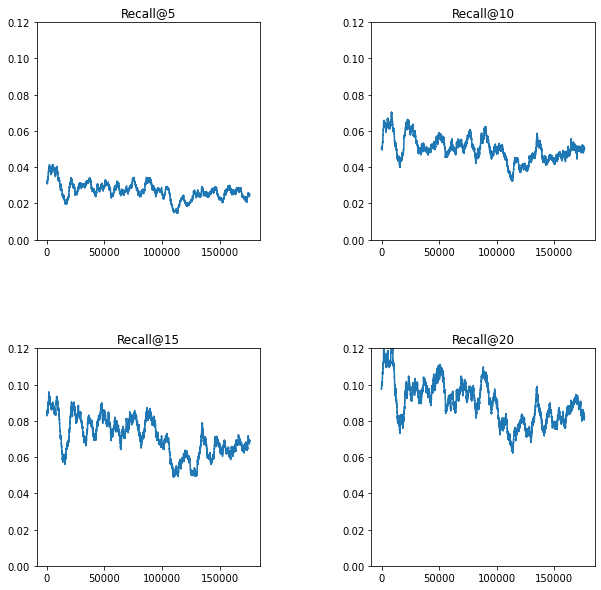

In [41]:
figure, axis = plt.subplots(2, 2, figsize=(10,10))
figure.subplots_adjust(wspace=0.5, hspace=0.5)

axis[0, 0].plot(avgs_only5_5)
axis[0, 0].set_title("Recall@5")
axis[0, 0].set_ylim(0., 0.12)

axis[0, 1].plot(avgs_only5_10)
axis[0, 1].set_title("Recall@10")
axis[0, 1].set_ylim(0., 0.12)

axis[1, 0].plot(avgs_only5_15)
axis[1, 0].set_title("Recall@15")
axis[1, 0].set_ylim(0., 0.12)

axis[1, 1].plot(avgs_only5_20)
axis[1, 1].set_title("Recall@20")
axis[1, 1].set_ylim(0., 0.12)

plt.show()

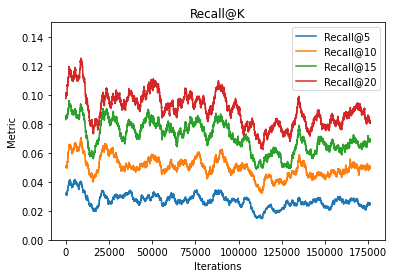

In [42]:
plt.title('Recall@K')
plt.xlabel('Iterations')
plt.ylabel('Metric')
plt.ylim(0., 0.15)
plt.plot(avgs_only5_5, label = "Recall@5")
plt.plot(avgs_only5_10, label = "Recall@10")
plt.plot(avgs_only5_15, label = "Recall@15")
plt.plot(avgs_only5_20, label = "Recall@20")
plt.legend()
plt.show()

Pripremimo sada "relaksiraniji" skup podataka koji će kao poyitivne ocene smatrati ocene i 4 i 5 i proverimo koliko podataka dobijamo u slučaju takvog problema.

In [43]:
ratings_df_5and4 = prepare_data(ratings_df, 4, True)
ratings_df_5and4.head()

Broj korisnika nakon filtiranja: 6038
Broj filmova nakon filtriranja: 3533
Broj ocena nakon filtriranja: 575281


,user_code,movie_code,rating,timestamp
0,0,1039,5,978300760
3,0,3027,4,978300275
4,0,2053,5,978824291
6,0,1130,5,978302039
7,0,2476,5,978300719


Na isti način kao malopre primenimo algoritam na novodobijeni skup podataka u slučaju da nam treba 5, 10, 15, odnosno 20 predloga i iscrtajmo dobijene rezultate.

In [44]:
avgs_5and4_5, isgd = start_incremental_sgd(ratings_df_5and4, N=5)

100%|██████████| 460225/460225 [05:52<00:00, 1306.90it/s]


In [45]:
avgs_5and4_10, isgd = start_incremental_sgd(ratings_df_5and4, N=10)

100%|██████████| 460225/460225 [05:49<00:00, 1315.00it/s]


In [46]:
avgs_5and4_15, isgd = start_incremental_sgd(ratings_df_5and4, N=15)

100%|██████████| 460225/460225 [05:51<00:00, 1307.57it/s]


In [47]:
avgs_5and4_20, isgd = start_incremental_sgd(ratings_df_5and4, N=20)

100%|██████████| 460225/460225 [05:55<00:00, 1292.86it/s]


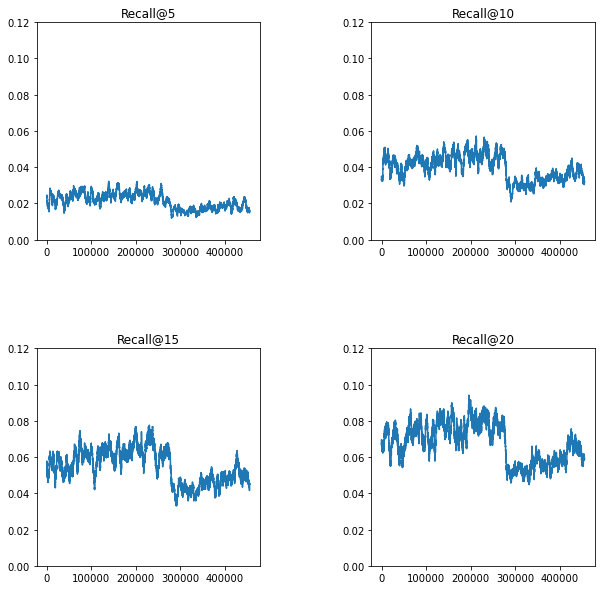

In [48]:
figure, axis = plt.subplots(2, 2, figsize=(10,10))
figure.subplots_adjust(wspace=0.5, hspace=0.5)

axis[0, 0].plot(avgs_5and4_5)
axis[0, 0].set_title("Recall@5")
axis[0, 0].set_ylim(0., 0.12)

axis[0, 1].plot(avgs_5and4_10)
axis[0, 1].set_title("Recall@10")
axis[0, 1].set_ylim(0., 0.12)

axis[1, 0].plot(avgs_5and4_15)
axis[1, 0].set_title("Recall@15")
axis[1, 0].set_ylim(0., 0.12)

axis[1, 1].plot(avgs_5and4_20)
axis[1, 1].set_title("Recall@20")
axis[1, 1].set_ylim(0., 0.12)

plt.show()

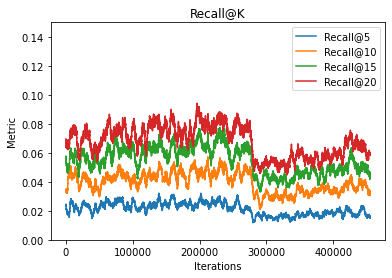

In [49]:
plt.title('Recall@K')
plt.xlabel('Iterations')
plt.ylabel('Metric')
plt.ylim(0., 0.15)
plt.plot(avgs_5and4_5, label = "Recall@5")
plt.plot(avgs_5and4_10, label = "Recall@10")
plt.plot(avgs_5and4_15, label = "Recall@15")
plt.plot(avgs_5and4_20, label = "Recall@20")
plt.legend()
plt.show()

Pogledajmo sada i uporedni prikaz rada algoritma nad oba skupa podataka. Možemo primetiti da je u prilikom posmatranja manjeg broja vrednosti rezultat nad relaksiranim skupom podataka bolji, dok se nakon dostizanja određene količine podataka razlika između ponašanja algoritma nad različitim skupovima podataka smanjuje i njihovi rezultati postaju veoma bliski.

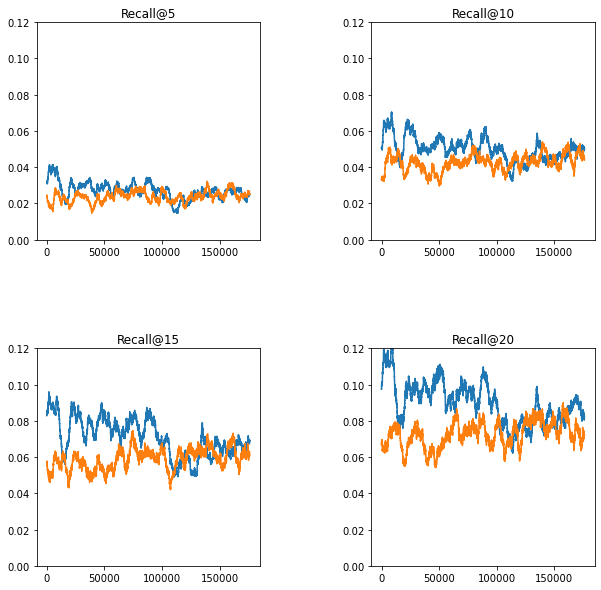

In [51]:
figure, axis = plt.subplots(2, 2, figsize=(10,10))
figure.subplots_adjust(wspace=0.5, hspace=0.5)

axis[0, 0].plot(avgs_only5_5)
axis[0, 0].plot(avgs_5and4_5[:len(avgs_only5_5)])
axis[0, 0].set_title("Recall@5")
axis[0, 0].set_ylim(0., 0.12)

axis[0, 1].plot(avgs_only5_10)
axis[0, 1].plot(avgs_5and4_10[:len(avgs_only5_10)])
axis[0, 1].set_title("Recall@10")
axis[0, 1].set_ylim(0., 0.12)

axis[1, 0].plot(avgs_only5_15)
axis[1, 0].plot(avgs_5and4_15[:len(avgs_only5_15)])
axis[1, 0].set_title("Recall@15")
axis[1, 0].set_ylim(0., 0.12)

axis[1, 1].plot(avgs_only5_20)
axis[1, 1].plot(avgs_5and4_20[:len(avgs_only5_20)])
axis[1, 1].set_title("Recall@20")
axis[1, 1].set_ylim(0., 0.12)

plt.show()

Kreirajmo sada i skup podataka koji ćemo koristiti za prikaz rada cf_step biblioteke. Kreiraćemo skup podataka sa relaksiranijim uslovima, odnosno posmatrati i ocene 4 i 5, i označićemo da je potrebno da nam se kreira nova kolona preference koja će nam biti potrebna za dalji rad sa ovom bibliotekom.

In [52]:
ratings_df_5and4_with_preference = prepare_data(ratings_df, 4, True, True)
ratings_df_5and4_with_preference.head()

Broj korisnika nakon filtiranja: 6038
Broj filmova nakon filtriranja: 3533
Broj ocena nakon filtriranja: 575281


,user_code,movie_code,rating,timestamp,preference
0,0,1039,5,978300760,1
3,0,3027,4,978300275,1
4,0,2053,5,978824291,1
6,0,1130,5,978302039,1
7,0,2476,5,978300719,1


Učitaćemo i dodatne biblioteke koje nam do sada nisu bile potrebne, ali koje ćemo koristiti u nastavku.

In [53]:
# U nastavku se koristi cf_step biblioteka, importujemo neophodne stvari
# Instalacija sa pip install cf_step
import torch
import torch.nn as nn

from torch.optim import SGD
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from cf_step.step import Step
from cf_step.networks import SimpleCF
from cf_step.metrics import recall_at_k
from cf_step.utils import moving_avg

Kreiramo cf_model koristeći iste vrednosti koje smo koristili za ISGD kako bismo mogli da poredimo rezultate. Takođe, ponovo 20% podataka koristimo ya inicijalno treniranje, nakon čega nastavljamo sa inkrementalnim učenjem nad preostalim podacima.

In [54]:
# Kreiramo model
net = SimpleCF(n_users, n_movies, factors=128, init=torch.nn.init.normal_, mean=0.0, std=0.1)
objective = lambda pred, target: target - pred
optimizer = SGD(net.parameters(), lr=0.05)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Step(net, objective, optimizer, device=device)

# Treniramo na 20% podataka
n_train = int(ratings_df_5and4_with_preference.shape[0] * 0.2)
train_data = ratings_df_5and4_with_preference.head(n_train)
features = ['user_code', 'movie_code', 'rating']
target = ['preference']
data_set = TensorDataset(torch.tensor(train_data[features].values), torch.tensor(train_data[target].values))
data_loader = DataLoader(data_set, batch_size=512, shuffle=False)
model.batch_fit(data_loader)

100%|██████████| 225/225 [00:02<00:00, 100.15it/s]


Kako smo izdvojili deo skupa podataka za treniranje, dropujemo ga kako bi izdvojili onaj deo skupa podataka koji ćemo koristiti dalje.

In [55]:
# Preostali podaci
data_step = ratings_df_5and4_with_preference.drop(train_data.index)
data_step = data_step.reset_index(drop=True)
data_step.head()

,user_code,movie_code,rating,timestamp,preference
0,1241,3491,4,974831562,1
1,1241,1074,5,974832798,1
2,1241,1080,5,974909219,1
3,1241,1082,5,976307745,1
4,1241,965,4,974834150,1


Pokrećemo cf_step na ostatku podataka i računamo recall kao što smo radili i za SGD. Vidimo da je vreme potrebno za izvršavanje ovde višestruko veće u odnosu na SGD, u slučaju koričćenja SGD ovaj deo je trajao nešto više od 12 minuta, dok ovde traje nešto više od 45 minuta.

In [56]:
# Pokretanje na ostatku podataka
stream_data_set = TensorDataset(torch.tensor(data_step[features].values), torch.tensor(data_step[target].values))
stream_data_loader = DataLoader(stream_data_set, batch_size=1, shuffle=False)
recalls = []
known_users = []

with tqdm(total=len(stream_data_loader)) as pbar:
    for (features, preferences) in stream_data_loader:
        user = features[:, 0]
        movie = features[:, 1]
        rating = features[:, 2]
        preference = preferences
        if user.item() in known_users:
            predictions = model.predict(user, 10)
            recall = recall_at_k(predictions.tolist(), movie.tolist(), 10)
            recalls.append(recall)
            model.step(user, movie, rating, preference)
        else:
            model.step(user, movie, rating, preference)
        known_users.append(user.item())
        pbar.update(1)

100%|██████████| 460225/460225 [1:00:43<00:00, 126.31it/s]


In [57]:
avgs_cf_step = moving_avg(recalls, 5000)

Najpre prikažimo samo rezultate cf_step.

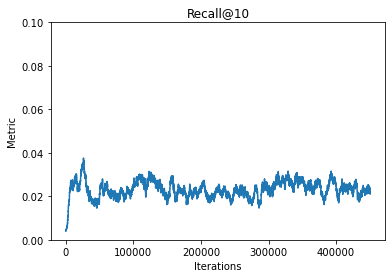

In [58]:
plt.title('Recall@10')
plt.xlabel('Iterations')
plt.ylabel('Metric')
plt.ylim(0., 0.1)
plt.plot(avgs_cf_step)
plt.show()

I na kraju prikažimo još i sve rezultate dobijene za slučaj 10 ponuđenih predloga uporedo za sve slučajeve koje smo posmatrali.  

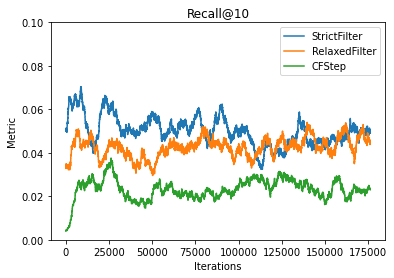

In [59]:
plt.title('Recall@10')
plt.xlabel('Iterations')
plt.ylabel('Metric')
plt.ylim(0., 0.1)
plt.plot(avgs_only5_10, label = "StrictFilter")
plt.plot(avgs_5and4_10[:len(avgs_only5_10)], label = "RelaxedFilter")
plt.plot(avgs_cf_step[:len(avgs_only5_10)], label = "CFStep")
plt.legend()
plt.show()